In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from scimba_jax.linear_approximation.meshes.meshes1d import Mesh1D
from scimba_jax.linear_approximation.quad.gauss_quad import UnitSquareTensorized
from scimba_jax.mapping.mapping import Mapping, InvertibleFunction

Scimba_jax uses device: [CudaDevice(id=0)]
Scimba_jax uses dtype: <class 'jax.numpy.float64'>


## Maillage 1D

In [2]:
# Créer une quadrature 1D avec ordre 2
quad_1d = UnitSquareTensorized(dim=1, order=2)

# Créer un mapping trivial (identité sur [0,1])
identity = InvertibleFunction(
    f=lambda x: x,      # f(x) = x
    f_inv=lambda y: y   # f^-1(y) = y
)
mapping = Mapping([identity])

# Créer le maillage 1D avec 10 cellules
mesh_1d = Mesh1D(
    dim=1,
    n_cells=10,
    ref_quad=quad_1d,
    mapping=mapping
)

print("✓ Maillage 1D créé !")
print(f"  - Dimension: {mesh_1d.dim}")
print(f"  - Nombre de cellules: {mesh_1d.n_cells}")
print(f"  - Nombre total de cellules: {mesh_1d.n_cells_total}")
print(f"  - Points de quadrature par cellule: {mesh_1d.n_gauss}")
print(f"  - Nombre de faces: {mesh_1d.n_faces}")

✓ Maillage 1D créé !
  - Dimension: 1
  - Nombre de cellules: 10
  - Nombre total de cellules: 10
  - Points de quadrature par cellule: 2
  - Nombre de faces: 11


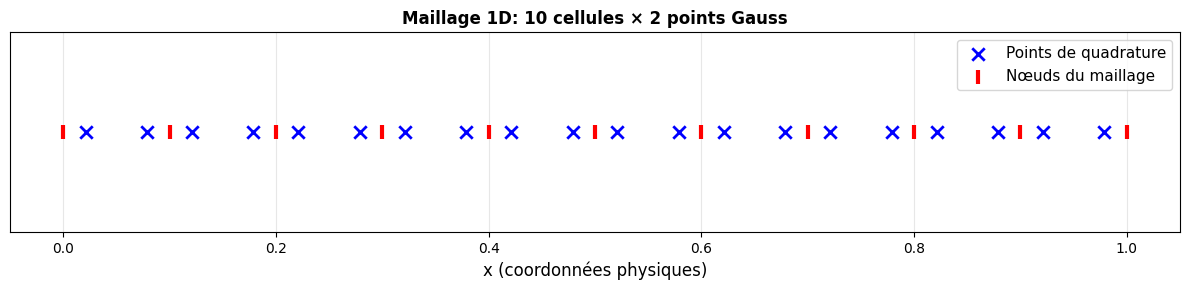

✓ Maillage 1D visualisé:
  • Nœuds: 11
  • Cellules: 10
  • Points Gauss/cellule: 2
  • Total points quadrature: 20


In [3]:
# Plot simplifié du mesh_1d
plt.close('all')  # Fermer toutes les figures précédentes
fig, ax = plt.subplots(figsize=(12, 3))

# Récupérer tous les points de quadrature via la classe
quad_points = mesh_1d.evaluate_mesh_points()  # shape: (n_cells, n_gauss, 1)
quad_points_flat = np.asarray(quad_points).flatten()

# Nœuds du maillage
mesh_nodes_logical = mesh_1d.n_i_faces / mesh_1d.n_cells
mesh_nodes_phys = np.asarray(mesh_1d.mapping.local_mapping(mesh_nodes_logical))

# Affichage
ax.scatter(quad_points_flat, np.zeros_like(quad_points_flat), s=80, c='blue', marker='x', linewidths=2, label='Points de quadrature', zorder=4)
ax.scatter(mesh_nodes_phys, np.zeros_like(mesh_nodes_phys), s=100, c='red', marker='|', linewidths=3, label='Nœuds du maillage', zorder=5)

ax.set_xlabel('x (coordonnées physiques)', fontsize=12)
ax.set_ylabel('')
ax.set_title(f'Maillage 1D: {mesh_1d.n_cells} cellules × {mesh_1d.n_gauss} points Gauss', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([-0.1, 0.1])
ax.set_yticks([])

plt.tight_layout()
plt.show()

print(f"✓ Maillage 1D visualisé:")
print(f"  • Nœuds: {mesh_1d.n_faces}")
print(f"  • Cellules: {mesh_1d.n_cells}")
print(f"  • Points Gauss/cellule: {mesh_1d.n_gauss}")
print(f"  • Total points quadrature: {mesh_1d.n_cells * mesh_1d.n_gauss}")

## Problème linéaire 1D

Considérons le problème de Poisson 1D avec terme de masse : $\qquad \alpha = 5$

$$\left\{\begin{align*}
-u''(x)+\alpha u(x) &= f(x),\quad x\in(0,1) \\
u(0) = u(1) &= 0\end{align*}\right.$$

Schéma différences finies centré d'ordre 2 sur un maillage uniforme : 

$$\left\{\begin{align*}
-u_{i+1}+2u_i-u_{i-1} + \alpha h^2 u_i &= h^2f_i,\quad i=1,\ldots,N-1 \\
u_0 = u_N &= 0\end{align*}\right.$$ 

Ce système est **linéaire**, on peut donc le résoudre **directement** :

$$A\mathbf{u} = \mathbf{f}$$

avec $A$, $\mathbf{u}$ et $\mathbf{f}$ définis par :

$$A = \frac{1}{h^2}\begin{pmatrix}
2+\alpha h^2 & -1 & 0 & \cdots & 0 \\
-1 & 2+\alpha h^2 & -1 & \cdots & 0 \\
0 & -1 & 2+\alpha h^2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & 2+\alpha h^2
\end{pmatrix}, \quad \mathbf{u} = \begin{pmatrix}
u_1 \\ u_2 \\ u_3 \\ \vdots \\ u_{N-1}
\end{pmatrix}, \quad \mathbf{f} = \begin{pmatrix}
f_1 \\ f_2 \\ f_3 \\ \vdots \\ f_{N-1}
\end{pmatrix}$$

In [4]:
# Paramètres du problème
alpha = 5.0  # Coefficient du terme de masse

# Utiliser les nœuds intérieurs du maillage comme points de résolution
mesh_nodes_logical = mesh_1d.n_i_faces / mesh_1d.n_cells  # [0, 1/10, 2/10, ..., 1]
mesh_nodes_phys = np.asarray(mesh_1d.mapping.local_mapping(mesh_nodes_logical))

# Points intérieurs (excluant les bords)
x_int = mesh_nodes_phys[1:-1]
N_int = len(x_int) # Nombre de nœuds intérieurs
N = N_int + 2  # Nombre total de nœuds (incluant les bords)
h = mesh_nodes_phys[1] - mesh_nodes_phys[0]  # Pas d'espace (obtenu du maillage)

# Source f(x) = sin(pi*x)
f_rhs = (alpha + jnp.pi**2) * jnp.sin(jnp.pi * x_int)

# Définir la fonction F(u) pour la Jacobienne
def F(u_int, h, alpha):
    # Reconstruire u avec conditions de Dirichlet aux bords
    u = jnp.concatenate([jnp.array([0.0]), u_int, jnp.array([0.0])])
    # Laplacien par DF centré: -u''
    laplacian = -(u[2:] - 2*u[1:-1] + u[:-2]) / h**2
    # Terme de masse: alpha*u
    mass = alpha * u_int
    return laplacian + mass

# Construire la matrice A via la Jacobienne
u_guess = jnp.zeros(N_int)
A = jax.jacobian(F)(u_guess, h, alpha)

# Résoudre: u = A^-1 * f
u_int_sol = jnp.linalg.solve(A, f_rhs)

# Reconstruire la solution complète avec les bords
u_sol_complete = jnp.concatenate([jnp.array([0.0]), u_int_sol, jnp.array([0.0])])
x_complete = mesh_nodes_phys

In [5]:
# Vérification que A est constante (indépendante de u)
# Calculer la Jacobienne pour différentes valeurs de u_int
u_test1 = jnp.zeros(N_int)
u_test2 = jnp.ones(N_int)
u_test3 = jnp.sin(jnp.pi * x_int)

A1 = jax.jacobian(F)(u_test1, h, alpha)
A2 = jax.jacobian(F)(u_test2, h, alpha)
A3 = jax.jacobian(F)(u_test3, h, alpha)

# Vérifier que les matrices sont identiques
diff_12 = jnp.max(jnp.abs(A1 - A2))
diff_13 = jnp.max(jnp.abs(A1 - A3))
diff_23 = jnp.max(jnp.abs(A2 - A3))

print("✓ Vérification que A est constante par rapport à u (problème linéaire):")
print(f"  • max|A(u=0) - A(u=1)| = {diff_12:.6e}")
print(f"  • max|A(u=0) - A(u=sin)| = {diff_13:.6e}")
print(f"  • max|A(u=1) - A(u=sin)| = {diff_23:.6e}")
if diff_12 < 1e-14 and diff_13 < 1e-14 and diff_23 < 1e-14:
    print(f"  ✓ A est bien constante (indépendante de u)")
else:
    print(f"  ⚠ A varie avec u (problème possiblement non-linéaire)")

✓ Vérification que A est constante par rapport à u (problème linéaire):
  • max|A(u=0) - A(u=1)| = 0.000000e+00
  • max|A(u=0) - A(u=sin)| = 0.000000e+00
  • max|A(u=1) - A(u=sin)| = 0.000000e+00
  ✓ A est bien constante (indépendante de u)


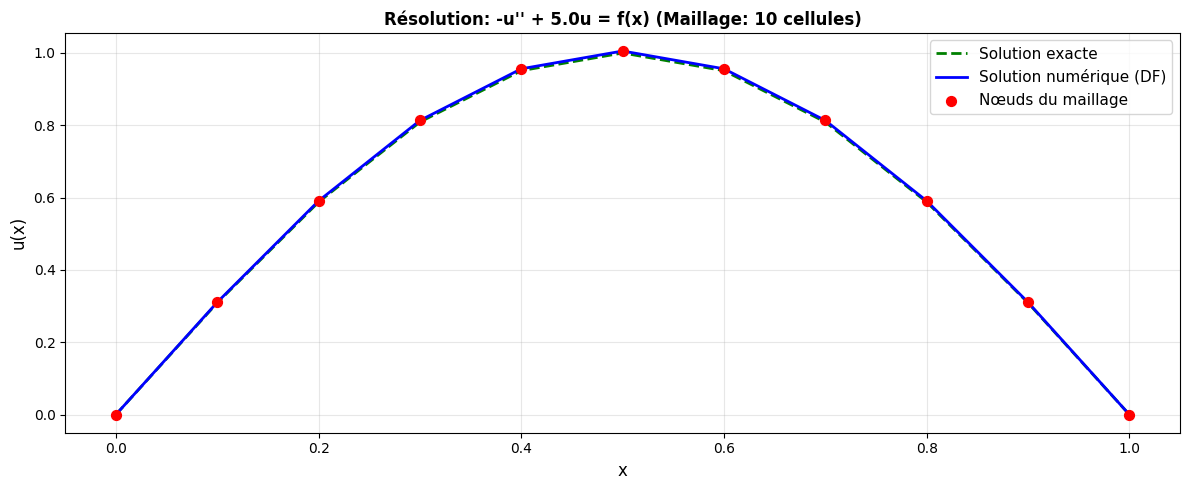

✓ Problème résolu avec Mesh1D:
  • Nœuds utilisés: 11 (dont 9 intérieurs)
  • Pas d'espace: 0.1000
  • Erreur L2: 3.868519e-03
  • Résidu (max): 4.085621e-14


In [6]:
# Solution analytique pour comparaison
u_exact = jnp.sin(jnp.pi * x_complete)

# Plot
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(x_complete, u_exact, 'g--', linewidth=2, label='Solution exacte')
ax.plot(x_complete, u_sol_complete, 'b-', linewidth=2, label='Solution numérique (DF)')

# Marquer les nœuds du maillage
ax.scatter(x_complete, u_sol_complete, c='red', s=50, zorder=5, label='Nœuds du maillage')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('u(x)', fontsize=12)
ax.set_title(f'Résolution: -u\'\' + {alpha}u = f(x) (Maillage: {mesh_1d.n_cells} cellules)', fontsize=12, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Erreur L2
error_l2 = np.sqrt(np.trapezoid((u_sol_complete - u_exact)**2, x_complete))
print(f"✓ Problème résolu avec Mesh1D:")
print(f"  • Nœuds utilisés: {N} (dont {N_int} intérieurs)")
print(f"  • Pas d'espace: {h:.4f}")
print(f"  • Erreur L2: {error_l2:.6e}")
print(f"  • Résidu (max): {np.max(np.abs(F(u_int_sol, h, alpha) - f_rhs)):.6e}")

## Problème non-linéaire 1D



Considérons maintenant un problème non-linéaire avec un terme quadratique : $\qquad \alpha = 5$

$$\left\{\begin{align*}
-u''(x)+\alpha u^2(x) &= f(x),\quad x\in(0,1) \\
u(0) = u(1) &= 0\end{align*}\right.$$

Schéma différences finies centré d'ordre 2 sur un maillage uniforme : 

$$\left\{\begin{align*}
-u_{i+1}+2u_i-u_{i-1} + \alpha h^2 u_i^2 &= h^2f_i,\quad i=1,\ldots,N-1 \\
u_0 = u_N &= 0\end{align*}\right.$$ 

Ce système est **non-linéaire**, on utilise donc la **méthode de Newton-Raphson** pour le résoudre :

$$\mathbf{u}^{(k+1)} = \mathbf{u}^{(k)} - J_F(\mathbf{u}^{(k)})^{-1} F(\mathbf{u}^{(k)})$$

où $F(\mathbf{u})$ est le résidu et $J_F$ sa Jacobienne.

In [7]:
# Paramètres du problème non-linéaire
alpha_nl = 5.0  # Coefficient du terme non-linéaire

# Récupérer les nœuds du maillage (indépendant de la section linéaire)
mesh_nodes_logical_nl = mesh_1d.n_i_faces / mesh_1d.n_cells
mesh_nodes_phys_nl = np.asarray(mesh_1d.mapping.local_mapping(mesh_nodes_logical_nl))

# Points intérieurs (excluant les bords)
x_int_nl = mesh_nodes_phys_nl[1:-1]
N_int_nl = len(x_int_nl)  # Nombre de nœuds intérieurs
N_nl = N_int_nl + 2  # Nombre total de nœuds (incluant les bords)
h_nl = mesh_nodes_phys_nl[1] - mesh_nodes_phys_nl[0]  # Pas d'espace

# Définir le résidu F(u) pour le problème non-linéaire
def F_nonlinear(u_int, h, alpha, x_int):
    # Reconstruire u avec conditions de Dirichlet aux bords
    u = jnp.concatenate([jnp.array([0.0]), u_int, jnp.array([0.0])])
    # Laplacien par DF centré: -u''
    laplacian = -(u[2:] - 2*u[1:-1] + u[:-2]) / h**2
    # Terme non-linéaire: alpha*u^2
    nonlinear_term = alpha * u_int**2
    # Second membre f(x) - pour avoir une solution proche de sin(pi*x), on ajuste f
    # f_rhs = f_source_nl(x_int, alpha)
    f_rhs = jnp.pi**2 * jnp.sin(jnp.pi * x_int) + alpha * jnp.sin(jnp.pi * x_int)**2
    return laplacian + nonlinear_term - f_rhs

# Méthode de Newton-Raphson
u_nl = jnp.zeros(N_int_nl)  # Initialisation
max_iter = 50
tol = 1e-10

jac_F = jax.jacobian(F_nonlinear, argnums=0)
for k in range(max_iter):
    # Calculer le résidu
    F_k = F_nonlinear(u_nl, h_nl, alpha_nl, x_int_nl)
    
    # Calculer la Jacobienne via JAX
    J_k = jac_F(u_nl, h_nl, alpha_nl, x_int_nl)
    
    # Résoudre le système linéaire: J * delta_u = -F
    delta_u = jnp.linalg.solve(J_k, -F_k)
    
    # Mise à jour
    u_nl = u_nl + delta_u
    
    # Critère de convergence
    residual_norm = jnp.linalg.norm(F_k)
    if residual_norm < tol:
        print(f"✓ Convergence atteinte en {k+1} itérations")
        print(f"  • Résidu final: {residual_norm:.6e}")
        break
else:
    print(f"⚠ Nombre maximum d'itérations atteint ({max_iter})")
    print(f"  • Résidu final: {residual_norm:.6e}")

# Reconstruire la solution complète avec les bords
u_nl_complete = jnp.concatenate([jnp.array([0.0]), u_nl, jnp.array([0.0])])
x_complete_nl = mesh_nodes_phys_nl

✓ Convergence atteinte en 6 itérations
  • Résidu final: 1.640728e-14


In [8]:
# Vérification que la Jacobienne dépend de u (problème non-linéaire)
# Calculer la Jacobienne pour différentes valeurs de u_int
u_test1_nl = jnp.zeros(N_int_nl)
u_test2_nl = 0.5 * jnp.ones(N_int_nl)
u_test3_nl = jnp.sin(jnp.pi * x_int_nl)

J_nl_1 = jax.jacobian(F_nonlinear)(u_test1_nl, h_nl, alpha_nl, x_int_nl)
J_nl_2 = jax.jacobian(F_nonlinear)(u_test2_nl, h_nl, alpha_nl, x_int_nl)
J_nl_3 = jax.jacobian(F_nonlinear)(u_test3_nl, h_nl, alpha_nl, x_int_nl)

# Vérifier que les matrices sont différentes
diff_nl_12 = jnp.max(jnp.abs(J_nl_1 - J_nl_2))
diff_nl_13 = jnp.max(jnp.abs(J_nl_1 - J_nl_3))
diff_nl_23 = jnp.max(jnp.abs(J_nl_2 - J_nl_3))

print("✓ Vérification que J dépend de u (problème non-linéaire):")
print(f"  • max|J(u=0) - J(u=0.5)| = {diff_nl_12:.6e}")
print(f"  • max|J(u=0) - J(u=sin)| = {diff_nl_13:.6e}")
print(f"  • max|J(u=0.5) - J(u=sin)| = {diff_nl_23:.6e}")
if diff_nl_12 > 1e-10 or diff_nl_13 > 1e-10 or diff_nl_23 > 1e-10:
    print(f"  ✓ J varie bien avec u (problème non-linéaire confirmé)")
else:
    print(f"  ⚠ J est constante (problème possiblement linéaire)")

✓ Vérification que J dépend de u (problème non-linéaire):
  • max|J(u=0) - J(u=0.5)| = 5.000000e+00
  • max|J(u=0) - J(u=sin)| = 1.000000e+01
  • max|J(u=0.5) - J(u=sin)| = 5.000000e+00
  ✓ J varie bien avec u (problème non-linéaire confirmé)


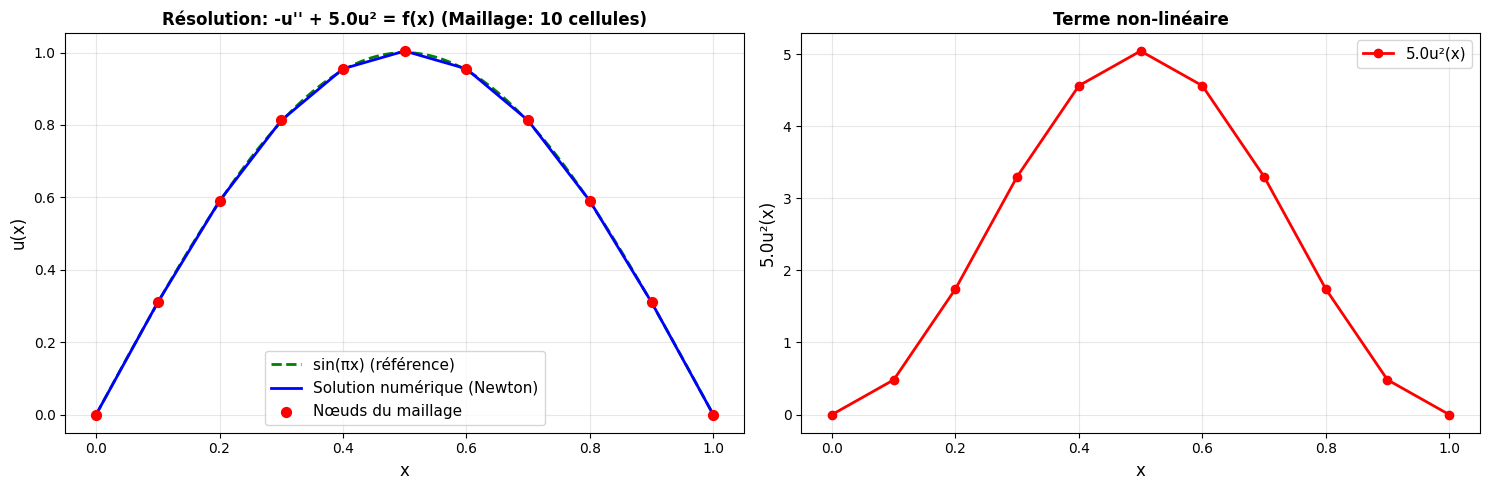

✓ Problème non-linéaire résolu:
  • Nœuds utilisés: 11 (dont 9 intérieurs)
  • Pas d'espace: 0.1000
  • Valeur max de u: 1.004350
  • Valeur max de 5.0u²: 5.043598


In [9]:
# Grille fine pour la solution de référence
x_fine_nl = jnp.linspace(0, 1, 1000)
# Solution de référence calculée numériquement (sin(pi*x) est une solution approchée)
u_ref_nl = jnp.sin(jnp.pi * x_fine_nl)

# Plot
plt.close('all')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1: Solution
ax1.plot(x_fine_nl, u_ref_nl, 'g--', linewidth=2, label='sin(πx) (référence)')
ax1.plot(x_complete_nl, u_nl_complete, 'b-', linewidth=2, label='Solution numérique (Newton)')
ax1.scatter(x_complete_nl, u_nl_complete, c='red', s=50, zorder=5, label='Nœuds du maillage')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('u(x)', fontsize=12)
ax1.set_title(f'Résolution: -u\'\' + {alpha_nl}u² = f(x) (Maillage: {mesh_1d.n_cells} cellules)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Graphique 2: Terme non-linéaire
nl_term = alpha_nl * u_nl_complete**2
ax2.plot(x_complete_nl, nl_term, 'r-', linewidth=2, marker='o', label=f'{alpha_nl}u²(x)')
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel(f'{alpha_nl}u²(x)', fontsize=12)
ax2.set_title('Terme non-linéaire', fontsize=12, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Problème non-linéaire résolu:")
print(f"  • Nœuds utilisés: {N_nl} (dont {N_int_nl} intérieurs)")
print(f"  • Pas d'espace: {h_nl:.4f}")
print(f"  • Valeur max de u: {jnp.max(u_nl_complete):.6f}")
print(f"  • Valeur max de {alpha_nl}u²: {jnp.max(nl_term):.6f}")